# **Quantum Machine Learning Course: Project - Space Debris Risk Challenge**

## **Introduction**
This project for the Quantum Machine Learning course, running from June 30 to July 6, 2025, focuses on predicting collision risk levels (0: Low Risk, 1: Moderate Risk, 2: High Risk) for space debris encounters in low Earth orbit (LEO). By 2030, over 30,000 satellites will face risks from millions of debris fragments, threatening critical infrastructure. The Space Debris Risk Dataset (SDRD) contains 5,000 training samples and 300 test samples, each with 40 features representing orbital and telemetry data with noise .

---

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from collections import Counter

# Dataset loading
train_df = pd.read_csv('train.csv') 
test_df = pd.read_csv('test.csv')

# **Preprocess data**

In [4]:
X = train_df.drop('risk_level', axis=1).values
y = train_df['risk_level'].values
X_test = test_df.values

- **Handle Missing Values**

In [5]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

- **Outlier Handling**

In [6]:
feature_names = test_df.columns  # original column names
X_df = pd.DataFrame(X_imputed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_imputed, columns=feature_names)

In [7]:
# Compute per-feature 1st and 99th percentiles
lower_bounds = X_df.quantile(0.01)
upper_bounds = X_df.quantile(0.99)

# Clip training and test data
X_df_clipped = X_df.clip(lower=lower_bounds, upper=upper_bounds, axis=1)
X_test_df_clipped = X_test_df.clip(lower=lower_bounds, upper=upper_bounds, axis=1)

- **Normalizing Inconsistent Units**

In [8]:
def normalize_units(df):
    df = df.copy()

    # Convert km to meters
    km_cols = ['semi_major_axis_km', 'apogee_km', 'perigee_km', 'miss_distance_km', 'sat_altitude_km']
    for col in km_cols:
        if col in df.columns:
            df[col] = df[col] * 1_000

    # Convert km/s to m/s
    kms_cols = ['relative_velocity_kms', 'sat_velocity_kms']
    for col in kms_cols:
        if col in df.columns:
            df[col] = df[col] * 1_000

    # Convert cm to meters
    if 'debris_size_cm' in df.columns:
        df['debris_size_cm'] = df['debris_size_cm'] / 100.0

    # Convert ms to seconds
    if 'ionospheric_delay_ms' in df.columns:
        df['ionospheric_delay_ms'] = df['ionospheric_delay_ms'] / 1000.0

    # Convert minutes to seconds
    if 'orbital_period_min' in df.columns:
        df['orbital_period_min'] = df['orbital_period_min'] * 60.0
    if 'collision_time_window_min' in df.columns:
        df['collision_time_window_min'] = df['collision_time_window_min'] * 60.0

    return df

X_df_normalized = normalize_units(X_df_clipped)
X_test_df_normalized = normalize_units(X_test_df_clipped)

- **Feature Engineering**

In [9]:
def environmental_features(df):
    # Environmental feature list
    env_features = ['solar_flux_index', 'geomagnetic_index', 'atmospheric_drag_coeff', 'ionospheric_delay_ms', 'space_weather_index']
    
    # Work on a copy to preserve the original DataFrame
    df_new = df.copy()

    # Extract and scale environmental data
    X = df_new[env_features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce to 1 component
    pca = PCA(n_components=1)
    df_new['space_weather_pca'] = pca.fit_transform(X_scaled)

    return df_new

X_environmental_features = environmental_features(X_df_normalized)
X_test_environmental_features = environmental_features(X_test_df_normalized)

In [10]:
def sensor_features(df):
    # Sensor-related feature list
    sensor_features = ['range_error_m', 'velocity_error_ms', 'sensor_noise_db', 'tracking_accuracy_m']
    
    # Work on a copy of the DataFrame
    df_new = df.copy()

    # Normalize the sensor data
    X_sensor = df_new[sensor_features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sensor)

    # Apply PCA to reduce to 1 component
    pca = PCA(n_components=1)
    df_new['sensor_quality_pca'] = pca.fit_transform(X_scaled)

    return df_new

X_sensor_features = sensor_features(X_environmental_features)
X_test_sensor_features = sensor_features(X_test_environmental_features)

In [11]:
def impact_features(df):
    # Impact-related features
    impact_features = ['material_density_kgm3', 'radar_cross_section_m2', 'debris_size_cm']
    
    # Copy the original DataFrame
    df_new = df.copy()

    # Normalize the impact features
    X_impact = df_new[impact_features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_impact)

    # PCA reduction to 1 components
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X_scaled)

    # Add both components to DataFrame
    df_new['debris_impact_pca'] = X_pca

    return df_new

X_impact_features = impact_features(X_sensor_features)
X_test_impact_features = impact_features(X_test_sensor_features)

In [12]:
def orbital_features(df):
    # Work on a copy of the DataFrame to preserve the original
    df_new = df.copy()
    
    # Compute mean altitude and range
    df_new['mean_altitude_km'] = (df_new['apogee_km'] + df_new['perigee_km']) / 2
    df_new['altitude_range_km'] = df_new['apogee_km'] - df_new['perigee_km']
    
    # Return the full updated DataFrame
    return df_new

X_orbital_features = orbital_features(X_impact_features)
X_test_orbital_features = orbital_features(X_test_impact_features)

In [13]:
def collision_physics_features(df):

    df_new = df.copy()

    # Relative velocity
    v_rel_kms = df_new['relative_velocity_kms']
    v_rel = v_rel_kms

    # Masses
    m_sat = df_new['sat_mass_kg']
    m_debris = df_new['debris_mass_kg']

    # Reduced mass (mu)
    mu = (m_sat * m_debris) / (m_sat + m_debris)

    # Relative kinetic energy
    df_new['relative_kinetic_energy'] = 0.5 * mu * v_rel**2

    # Relative momentum
    df_new['relative_momentum'] = mu * v_rel

    # Energy ratio (assumes debris kinetic energy is provided)
    df_new['energy_ratio'] = df_new['debris_kinetic_energy_j'] / df_new['sat_orbital_energy_j']

    # Mass ratio
    df_new['mass_ratio'] = m_debris / m_sat

    df_new['impact_parameter'] = df_new['debris_size_cm'] * df_new['relative_momentum']
    df_new["collision_energy_window"] = df_new["collision_time_window_min"] * df_new["relative_kinetic_energy"]
    
    return df_new

X_collision_physics_features = collision_physics_features(X_orbital_features)
X_test_collision_physics_features = collision_physics_features(X_test_orbital_features)

In [14]:
def closest_risk(df) :
    df_new = df.copy()

    df_new['closest_risk_prob'] = df_new['miss_distance_km'] * df_new['closest_approach_time_hr']

    return df_new

In [15]:
def drop_unused_raw_features(df):

    df_new = df.copy()

    features_to_drop = [
        # Environmental
        'solar_flux_index', 'geomagnetic_index',
        'atmospheric_drag_coeff', 'ionospheric_delay_ms', 'space_weather_index',

        # Sensor
        'range_error_m', 'velocity_error_ms',
        'sensor_noise_db', 'tracking_accuracy_m', 'elevation_deg', 'azimuth_deg',

        # Impact
        'material_density_kgm3', 'radar_cross_section_m2', 'debris_size_cm', 'debris_age_years',

        # Orbital
        'apogee_km', 'perigee_km', 'semi_major_axis_km',
        'eccentricity', 'orbital_period_min', 'right_ascension_deg', 'argument_perigee_deg', 'inclination_deg',

        # Collision physics
        'relative_velocity_kms', 'sat_mass_kg', 'debris_mass_kg',
        'sat_orbital_energy_j', 'debris_kinetic_energy_j','sat_power_w','sat_antenna_gain_db',
        'sat_velocity_kms','relative_momentum','relative_kinetic_energy',

        # collision risk features
        'miss_distance_km', 'closest_approach_time_hr','collision_time_window_min'
    ]

    # Drop only if the column exists
    df_new = df_new.drop(columns=[col for col in features_to_drop if col in df_new.columns])

    return df_new

In [16]:
def feature_engineering(df):
    df = closest_risk(df)
    df = drop_unused_raw_features(df)
    return df

X_final = feature_engineering(X_collision_physics_features)
X_test_final = feature_engineering(X_test_collision_physics_features)

# Re-impute after feature engineering
imputer_final = SimpleImputer(strategy='mean')
X_fe_imputed = imputer_final.fit_transform(X_final)
X_test_fe_imputed = imputer_final.transform(X_test_final)

- **Selected Features**

In [17]:
print("After feature engineering the selected features are :", X_final.columns.tolist())

After feature engineering the selected features are : ['relative_angular_momentum', 'collision_prob_raw', 'sat_altitude_km', 'orbital_energy_j', 'relative_inclination_deg', 'sat_maneuverability_score', 'space_weather_pca', 'sensor_quality_pca', 'debris_impact_pca', 'mean_altitude_km', 'altitude_range_km', 'energy_ratio', 'mass_ratio', 'impact_parameter', 'collision_energy_window', 'closest_risk_prob']


- **Splitting The Training Data**

In [18]:
# Split the dataset into training and validation sets
n = 1000

X_subset = X_fe_imputed[:n]
y_subset = y[:n]

X_train, X_val, y_train, y_val = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset
)

- **Check Class Balance**

Class Distribution:
 0    3503
1     754
2     743
dtype: int64


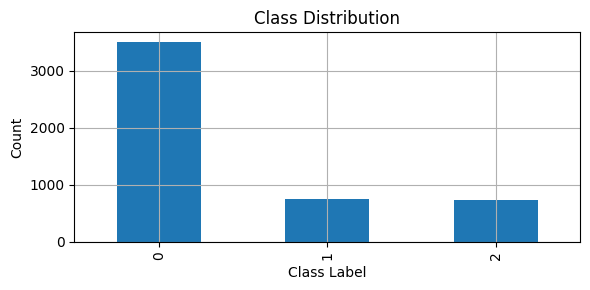

In [23]:
# 1. Check unique classes and their counts
unique, counts = np.unique(y, return_counts=True)
class_distribution = pd.Series(counts, index=unique)
print("Class Distribution:\n", class_distribution)

# 2. Plot class distribution
plt.figure(figsize=(6, 3))
class_distribution.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

- **Class Balancing**

In [24]:
class_counts = Counter(y_subset)

# Find the max class count (majority class)
max_count = max(class_counts.values()) 

# Compute weights
class_weights = {cls: max_count / count for cls, count in class_counts.items()}
class_weights = {int(k): v for k, v in class_weights.items()}

- **Feature Scaling**

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [26]:
# Check class distribution after resampling
print("Original y class distribution:", Counter(y_subset))
print("Class Weights:", class_weights)

Original y class distribution: Counter({np.int64(0): 713, np.int64(1): 150, np.int64(2): 137})
Class Weights: {0: 1.0, 2: 5.204379562043796, 1: 4.753333333333333}


- **Feature Reduction Using PCA**

In [27]:
pca = PCA(n_components=10)
X_selected = pca.fit_transform(X_train_scaled)
X_val_selected = pca.transform(X_val_scaled)
# Get the number of components selected
print(f"Number of components: {pca.n_components_}")

total_variance_captured = pca.explained_variance_ratio_.sum()
print(f"Total variance captured by {pca.n_components_} components: {total_variance_captured:.4f}")

Number of components: 10
Total variance captured by 10 components: 0.7446


In [28]:
print("Total No. of Initial Features : ",X.shape[1])
print("Total No. of Features after Feature Engineering : ",X_final.shape[1])
print("Total No. of Features after PCA: ",X_selected.shape[1])

Total No. of Initial Features :  40
Total No. of Features after Feature Engineering :  16
Total No. of Features after PCA:  10


# **Classical Model Training (SVM)**

- **Model**

In [29]:
# Initialize Classical SVM with RBF kernel (good for non-linear boundaries)
csvm = SVC(
    kernel='rbf',
    class_weight=class_weights,
    random_state=42
)
csvm.fit(X_selected, y_train)

SVC(class_weight={0: 1.0, 1: 4.753333333333333, 2: 5.204379562043796},
    random_state=42)

In [30]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
skf = StratifiedKFold(n_splits=5)

scores = cross_val_score(csvm, X_selected, y_train, cv=skf, scoring='f1_macro')
print("Cross-validated macro F1 score:", scores.mean())

Cross-validated macro F1 score: 0.35937104865783254


- **Predict on Validation Set**

In [31]:
y_val_pred = csvm.predict(X_val_selected)

- **Score Calculation**

In [32]:
def evaluate_classification(y_true, y_pred, model_name="Model"):

    print(f"\n📊 Evaluation Results for {model_name}:\n" + "-"*40)

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    print("✅ Balanced Accuracy Score:", round(balanced_acc, 4))

    # Macro F1
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print("✅ Macro F1 Score:", round(macro_f1, 4))

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()


📊 Evaluation Results for Classical SVM:
----------------------------------------
✅ Balanced Accuracy Score: 0.4197
✅ Macro F1 Score: 0.3699

📄 Classification Report:
              precision    recall  f1-score   support

           0     0.8090    0.5035    0.6207       143
           1     0.1224    0.2000    0.1519        30
           2     0.2419    0.5556    0.3371        27

    accuracy                         0.4650       200
   macro avg     0.3911    0.4197    0.3699       200
weighted avg     0.6295    0.4650    0.5121       200



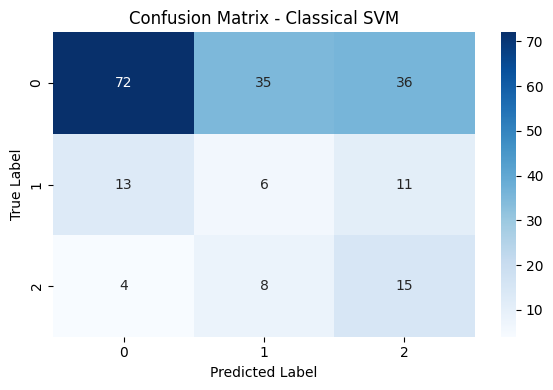

In [33]:
evaluate_classification(y_val, y_val_pred, model_name="Classical SVM")

# **Quantum Model Training (QSVM)**

In [ ]:
import pennylane as qml
import time
from tqdm import tqdm
from joblib import Parallel, delayed

- **Data Encoding**
- using PennyLane’s `lightning.qubit`

---

In [ ]:
num_qubits = X_selected.shape[1]
device = qml.device("lightning.qubit", wires=num_qubits)

# Step 5: Feature map
def encoding_data(x, wires):
    for i in range(len(x)):
        qml.Hadamard(wires=wires[i])
        qml.RZ(x[i], wires=wires[i])
    
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            qml.CNOT(wires=[wires[i], wires[j]])
            qml.RZ(x[i] * x[j], wires=wires[j])
            qml.CNOT(wires=[wires[i], wires[j]])

# Step 6: Define quantum kernel circuit
@qml.qnode(device)
def quantum_kernel(x1, x2):
    encoding_data(x1, wires=range(num_qubits))
    qml.adjoint(encoding_data)(x2, wires=range(num_qubits))
    return qml.expval(qml.Projector([0]*num_qubits, wires=range(num_qubits)))

- **Multi-Thread Processing**

In [ ]:
def compute_upper_triangle_row(i, X):
    row_values = []
    # Only compute for j >= i to get the upper triangle including the diagonal
    for j in range(i, len(X)):
        row_values.append(quantum_kernel(X[i], X[j]))
    return row_values

In [ ]:
def compute_row_general(i, X1, X2):
    return [quantum_kernel(X1[i], X2[j]) for j in range(len(X2))]

def parallel_qkernel(X1, X2, n_jobs=-1, label=""):
    print(f"🚀 Starting quantum kernel computation for {label}...")
    start_time = time.time()

    is_symmetric_case = (X1 is X2) # Check if X1 and X2 are the exact same object

    if is_symmetric_case:
        n_samples = len(X1)
        # Initialize an empty matrix
        kernel_matrix = np.zeros((n_samples, n_samples))

        # Use Parallel to compute only the upper triangular part
        upper_triangle_results = Parallel(n_jobs=n_jobs)(
            delayed(compute_upper_triangle_row)(i, X1)
            for i in tqdm(range(n_samples), desc=f"⏳ Building {label} Kernel (Symmetric)")
        )

        # Fill the symmetric matrix
        for i, row_values in enumerate(upper_triangle_results):
            for k, val in enumerate(row_values):
                j = i + k # Calculate the corresponding column index
                kernel_matrix[i, j] = val
                if i != j: # For off-diagonal elements, fill the symmetric counterpart
                    kernel_matrix[j, i] = val
    else:
        # For non-symmetric cases, use the original full computation
        results = Parallel(n_jobs=n_jobs)(
            delayed(compute_row_general)(i, X1, X2)
            for i in tqdm(range(len(X1)), desc=f"⏳ Building {label} Kernel")
        )
        kernel_matrix = np.array(results)

    total_time = time.time() - start_time
    print(f"✅ {label} kernel matrix computed in {total_time / 60:.2f} minutes ({total_time:.1f} seconds)")

    return kernel_matrix

- **Predict on Validation Set**

In [ ]:
K_train = parallel_qkernel(X_selected, X_selected, n_jobs=-1, label="Training")
K_val = parallel_qkernel(X_val_selected, X_selected, n_jobs=-1, label="Validation")

qsvm = SVC(kernel='precomputed', class_weight=class_weights, random_state=42)
qsvm.fit(K_train, y_train)
y_val_pred = qsvm.predict(K_val)

🚀 Starting quantum kernel computation for Training...


⏳ Building Training Kernel (Symmetric): 100%|██████████| 800/800 [31:01<00:00,  2.33s/it]


✅ Training kernel matrix computed in 31.05 minutes (1863.3 seconds)
🚀 Starting quantum kernel computation for Validation...


⏳ Building Validation Kernel: 100%|██████████| 200/200 [14:00<00:00,  4.20s/it]


✅ Validation kernel matrix computed in 15.81 minutes (948.8 seconds)


- **Score Calculation**


📊 Evaluation Results for Quantum SVM:
----------------------------------------
✅ Balanced Accuracy Score: 0.4483
✅ Macro F1 Score: 0.4406

📄 Classification Report:
              precision    recall  f1-score   support

           0     0.7681    0.7413    0.7544       143
           1     0.2692    0.2333    0.2500        30
           2     0.2778    0.3704    0.3175        27

    accuracy                         0.6150       200
   macro avg     0.4384    0.4483    0.4406       200
weighted avg     0.6271    0.6150    0.6198       200



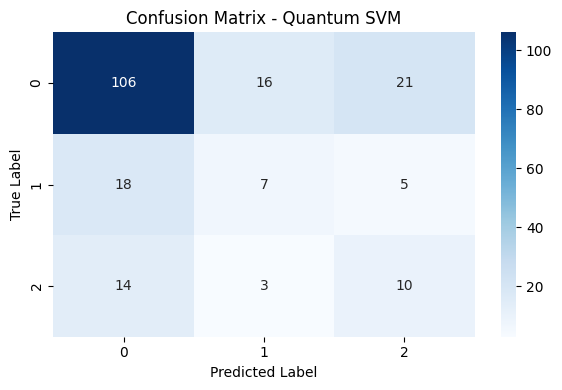

In [ ]:
evaluate_classification(y_val, y_val_pred, model_name="Quantum SVM")

- **Heat Map of Quantum Kernel Matrix (Train)**

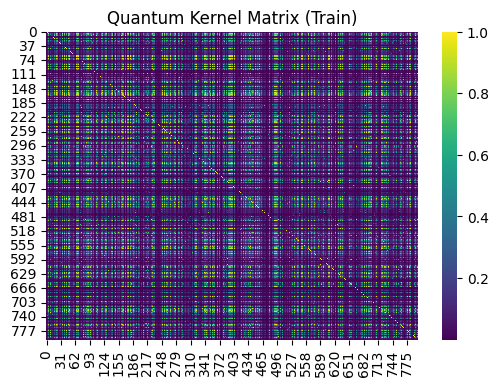

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(K_train, cmap='viridis')
plt.title("Quantum Kernel Matrix (Train)")
plt.show()

- **Rank of Quantum Kernel Matrix**

In [ ]:
eigvals = np.linalg.eigvalsh(K_train)
threshold = 1e-3
rank = np.sum(eigvals > threshold)
print(f"Effective rank (eigenvals > {threshold}):", rank)

Effective rank (eigenvals > 0.001): 673


- **Eigenvalue Spectrum of Quantum Kernel**

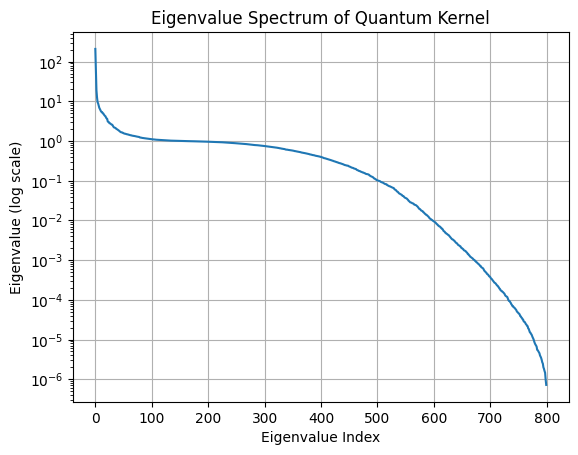

In [ ]:
eigvals = np.linalg.eigvalsh(K_train)
plt.plot(sorted(eigvals, reverse=True))
plt.yscale('log')
plt.title("Eigenvalue Spectrum of Quantum Kernel")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue (log scale)")
plt.grid(True)
plt.show()

# **Submission**

- A template for generating `predictions.csv`.

---

In [ ]:
X_test = X_test_fe_imputed[:300]
X_test_scaled = scaler.transform(X_test)
X_test_selected = pca.transform(X_test_scaled)

In [ ]:
test_pred_classical = csvm.predict(X_test_selected)
K_test = parallel_qkernel(X_test_selected, X_selected, n_jobs=-1, label="Prediction")
test_pred_quantum = qsvm.predict(K_test)

🚀 Starting quantum kernel computation for Prediction...


⏳ Building Prediction Kernel: 100%|██████████| 300/300 [22:49<00:00,  4.56s/it]


✅ Prediction kernel matrix computed in 24.35 minutes (1461.1 seconds)


In [ ]:
predictions = pd.DataFrame({
    'sample_id': range(len(X_test)),
    'label_classical': test_pred_classical,
    'label_quantum': test_pred_quantum
})
predictions.to_csv('predictions.csv', index=False)
